In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import sqlite3 as sl
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget
  

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(rc = {'figure.figsize':(15,8)})
sns.set_palette('tab10')


con = sl.connect(r'C:\CODE\learning\Apex_cluster\database\apex.db')
df = pd.read_sql("select * from api_rank_s13",con)

Basic cleaning

In [2]:
# drop nans for kills and zeros
df = df.dropna(subset=['kills', 'level'])
df = df[df['kills'] != 0]

# drop players in rookie rank
df = df[df['rank'] != 'Rookie']
print(len(df))
df.isnull().sum()

1121


uid                 0
username            0
level               0
rankscore           0
rank                0
skin                0
skinrarity          0
kd                  0
kills               0
damage            406
top_3            1007
games_played      917
date_accessed       0
dtype: int64

Feature engineering

In [3]:
df['kill_per_level'] = df['kills']/df['level']

In [4]:
# label encode skinrarity
df['skinrarity'] = df['skinrarity'].replace({'None':1, 'Common': 2, 'Rare': 3, 'Epic': 4, 'Legendary': 5})

In [5]:
scaler = MinMaxScaler()
df['kills_log'] = np.log(df['kills'])
df['level_log'] = np.log(df['level'])
df['kills_scaled'] = scaler.fit_transform(df[['kills']])
df['level_scaled'] = scaler.fit_transform(df[['level']])
df['level_log_scaled'] = scaler.fit_transform(df[['level_log']])
df['kills_log_scaled'] = scaler.fit_transform(df[['kills_log']])

Splitting sample by rank for testing

In [6]:
# seperating dataframes by rank
predator = df[df['rank'] == 'Apex Predator']
master = df[df['rank'] == 'Master']
diamond = df[df['rank'] == 'Diamond']
platinum = df[df['rank'] == 'Platinum']
gold = df[df['rank'] == 'Gold']
silver = df[df['rank'] == 'Silver']
bronze = df[df['rank'] == 'Bronze']


In [7]:
df_list = [predator, master, diamond, platinum, gold, silver, bronze]


In [8]:
for i in df_list:
    i.reset_index(inplace=True, drop=True)

Overall sample contextual anomaly testing (cross-sectional), identifying global outliers

Isolation Forest: sample is recursively partitioned based off the features in a Binary Search Tree structure, observations are measured in how easily they are isolated from the rest of the observations based off those partitions using path length. This algorithm does not use distance and thus the scale/distribution of the data does not need to be transformed. 

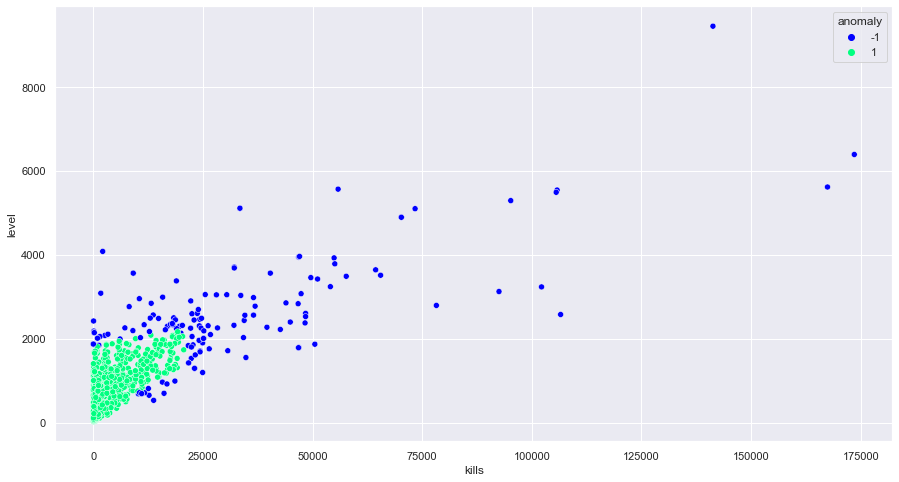

In [61]:
df.reset_index(inplace=True, drop=True)

clf = IsolationForest()
clf.fit(df[['kills','level']])
y_pred_train = clf.predict(df[['kills','level']])
df['anomaly'] = pd.Series(y_pred_train)
df['anomaly'] = df['anomaly'].replace(np.NaN, 0)

sns.scatterplot(x='kills', y='level', data=df, hue='anomaly',palette="winter")
plt.show()

In [62]:
df.value_counts('anomaly')

anomaly
 1    978
-1    143
dtype: int64

trying with transformation just to see

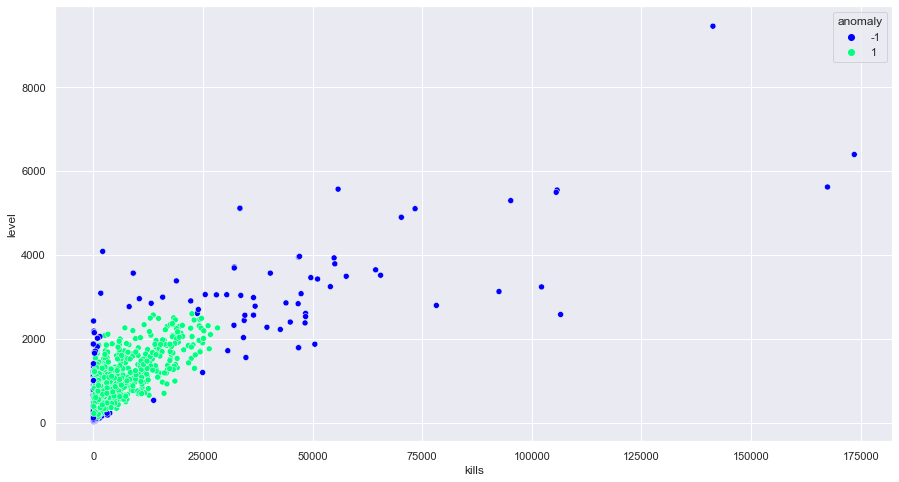

In [67]:
df.reset_index(inplace=True, drop=True)

clf = IsolationForest()
clf.fit(df[['kills_log_scaled','level_log_scaled']])
y_pred_train = clf.predict(df[['kills_log_scaled','level_log_scaled']])
df['anomaly'] = pd.Series(y_pred_train)
df['anomaly'] = df['anomaly'].replace(np.NaN, 0)

sns.scatterplot(x='kills', y='level', data=df, hue='anomaly',palette="winter")
plt.show()

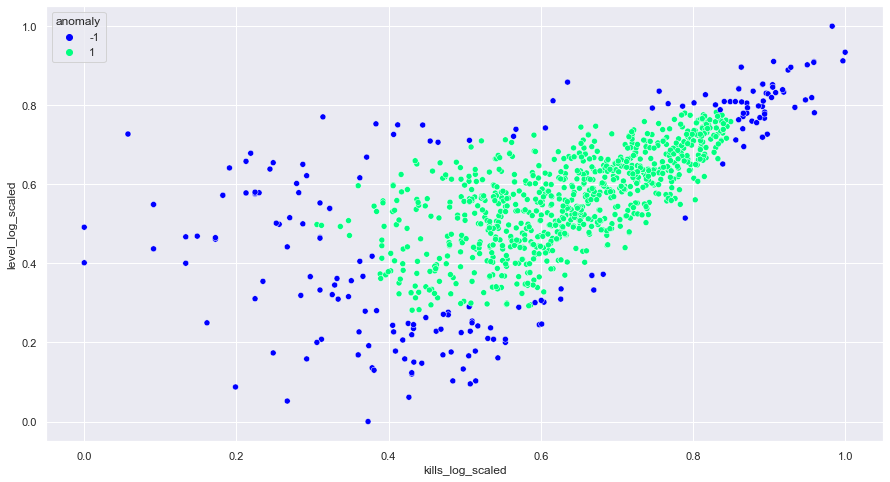

In [69]:
sns.scatterplot(x='kills_log_scaled', y='level_log_scaled', data=df, hue='anomaly',palette="winter")
plt.show()

In [70]:
df.value_counts('anomaly')

anomaly
 1    912
-1    209
dtype: int64

slight differences in how many outliers are found/ where they are found

In [10]:
df.reset_index(inplace=True, drop=True)

clf = IsolationForest(max_samples=300)
clf.fit(df[['kills','level','rankscore']])
y_pred_train = clf.predict(df[['kills','level','rankscore']])
df['anomaly'] = pd.Series(y_pred_train)
df['anomaly'] = df['anomaly'].replace(np.NaN, 0)

3d plot

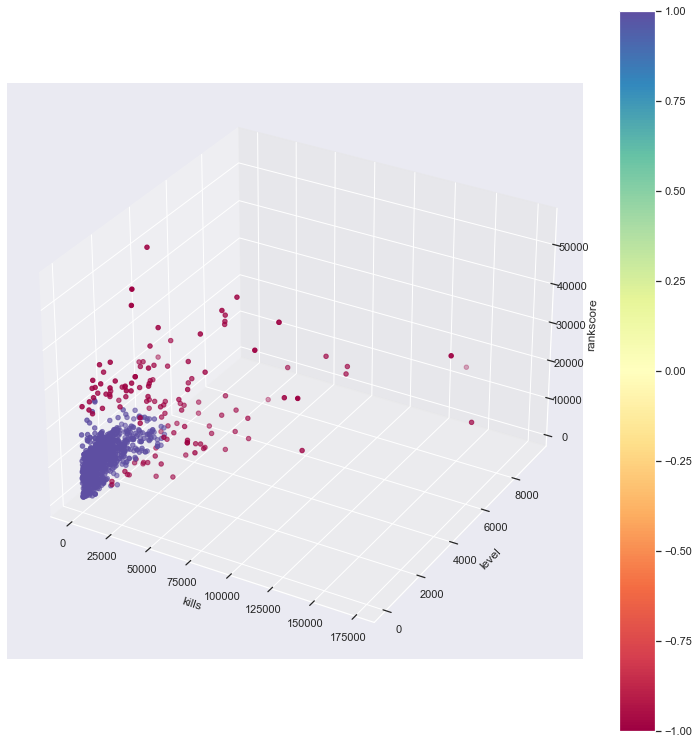

In [11]:
  
fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection = '3d')
ax = Axes3D(fig)

x = df['kills']
y = df['level']
z = df['rankscore']
c = df['anomaly']

ax.set_xlabel("kills")
ax.set_ylabel("level")
ax.set_zlabel("rankscore")
# label colors

color_map = "#9b59b6", "#e74c3c", "#34495e", "#2ecc71"
scat = ax.scatter(x, y, z, c=c, cmap='Spectral')
cb = plt.colorbar(scat)


plt.show()

Local outlier factor: measures outliers in degrees based off density. First calculates the reachability distance from all neighboors (K-distance neighborhood of given point) to the given point. Then calculates the local reachability density, or the inverse of the average of the reachability distances of all the neighboors from the given point. the LOF score is the average reachability distances of all neighboors of A divided by the local reachability density of the given point. Using a higher K value could potentially lead to the algorithm missing local anomilies while a lower k value could lead to noise detection. 

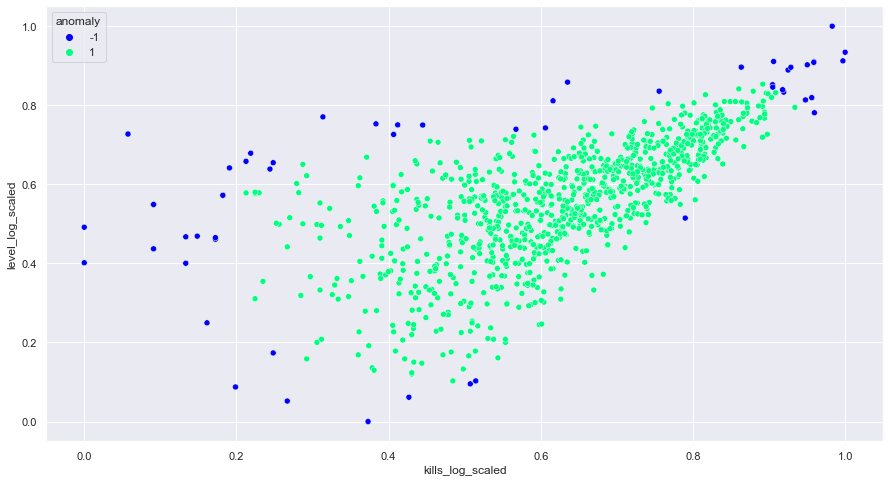

In [30]:

clf = LocalOutlierFactor(n_neighbors=100)
y_pred_train = clf.fit_predict(df[['kills_log_scaled','level_log_scaled']])
df['anomaly'] = pd.Series(y_pred_train)
df['anomaly'] = df['anomaly'].replace(np.NaN, 0)

sns.scatterplot(x='kills_log_scaled', y='level_log_scaled', data=df, hue='anomaly',palette="winter")
plt.show()

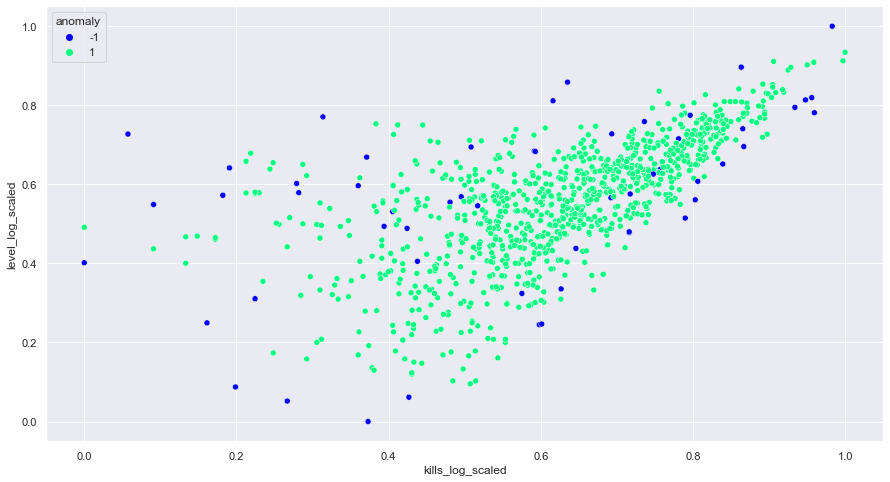

In [31]:
# low extreme
clf = LocalOutlierFactor(n_neighbors=5)
y_pred_train = clf.fit_predict(df[['kills_log_scaled','level_log_scaled']])
df['anomaly'] = pd.Series(y_pred_train)
df['anomaly'] = df['anomaly'].replace(np.NaN, 0)

sns.scatterplot(x='kills_log_scaled', y='level_log_scaled', data=df, hue='anomaly',palette="winter")
plt.show()

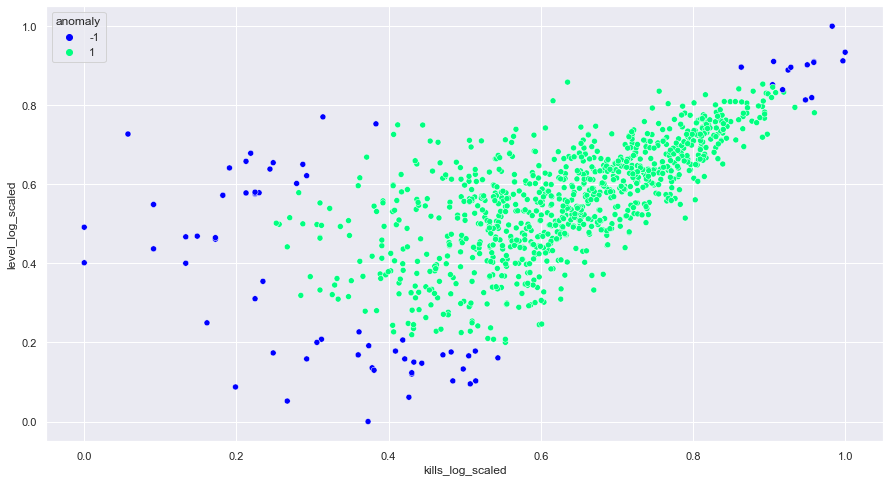

In [66]:
# High extreme
clf = LocalOutlierFactor(n_neighbors=500)
y_pred_train = clf.fit_predict(df[['kills_log_scaled','level_log_scaled']])
df['anomaly'] = pd.Series(y_pred_train)
df['anomaly'] = df['anomaly'].replace(np.NaN, 0)

sns.scatterplot(x='kills_log_scaled', y='level_log_scaled', data=df, hue='anomaly',palette="winter")
plt.show()

Isolation forest seemed to identify outliers more in line with intuition. Continuing with Isolation forest for rank sub samples.

In [71]:
# isolation forest
for i in df_list:
    clf = IsolationForest()
    clf.fit(i[['kills','level']])
    y_pred_train = clf.predict(i[['kills','level']])
    i['anomaly'] = pd.Series(y_pred_train)
    i['anomaly'] = i['anomaly'].replace(np.NaN, 0)


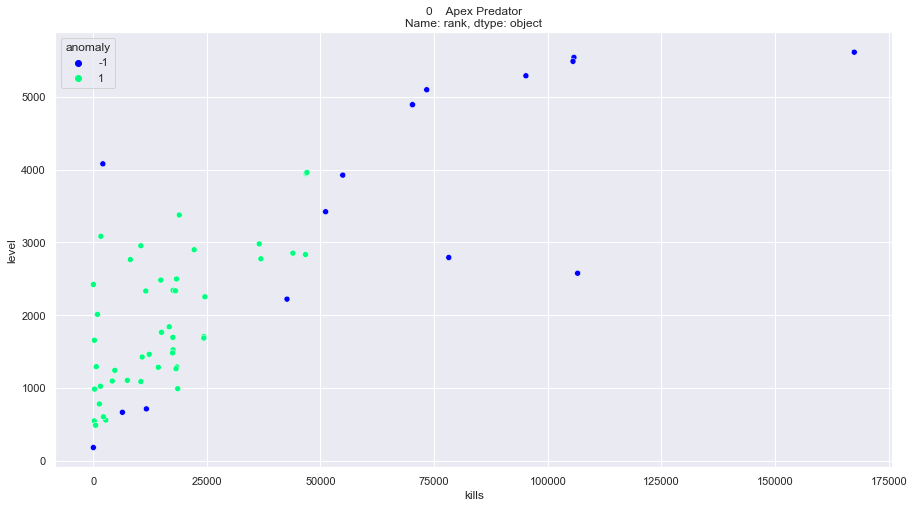

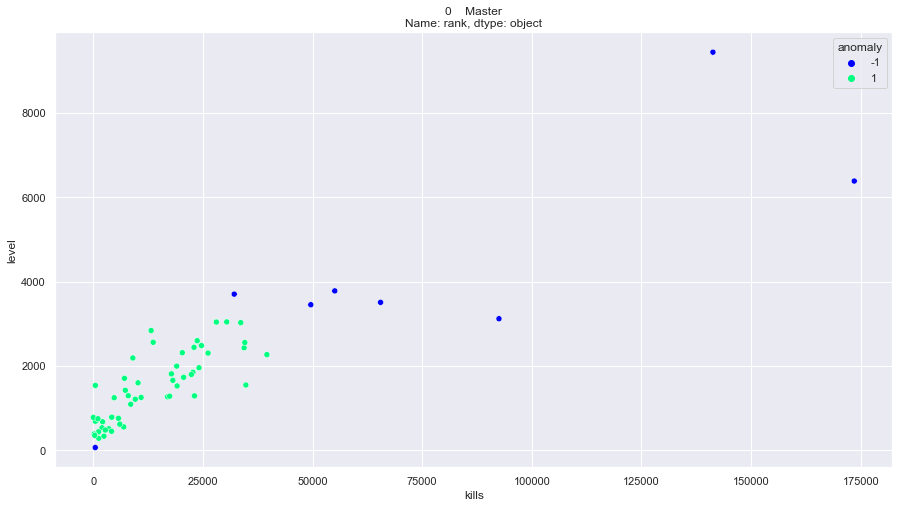

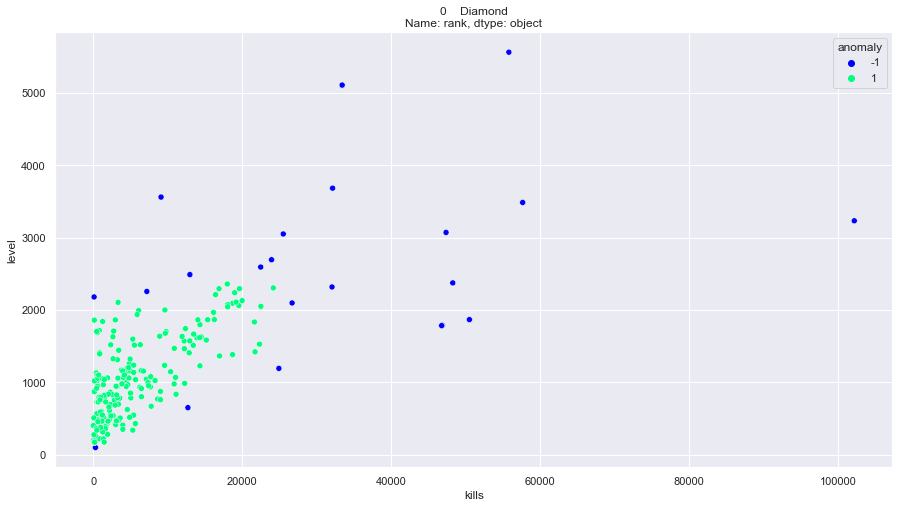

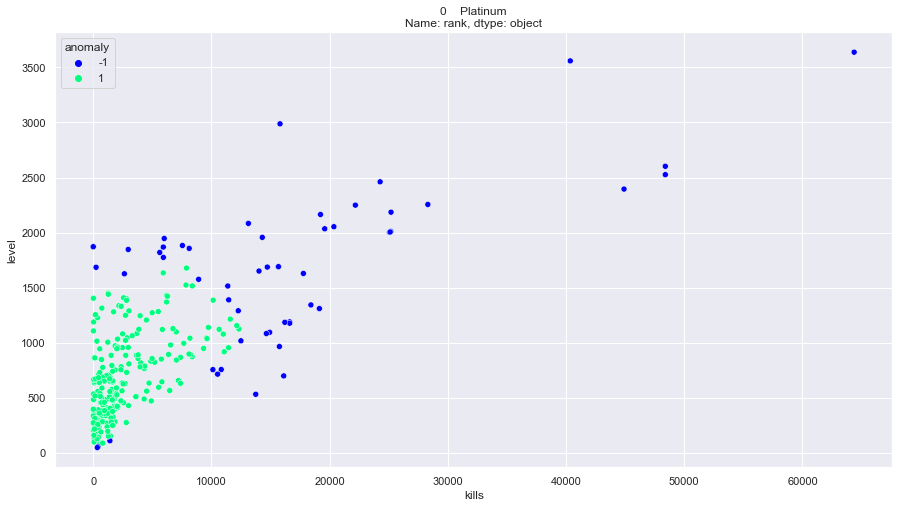

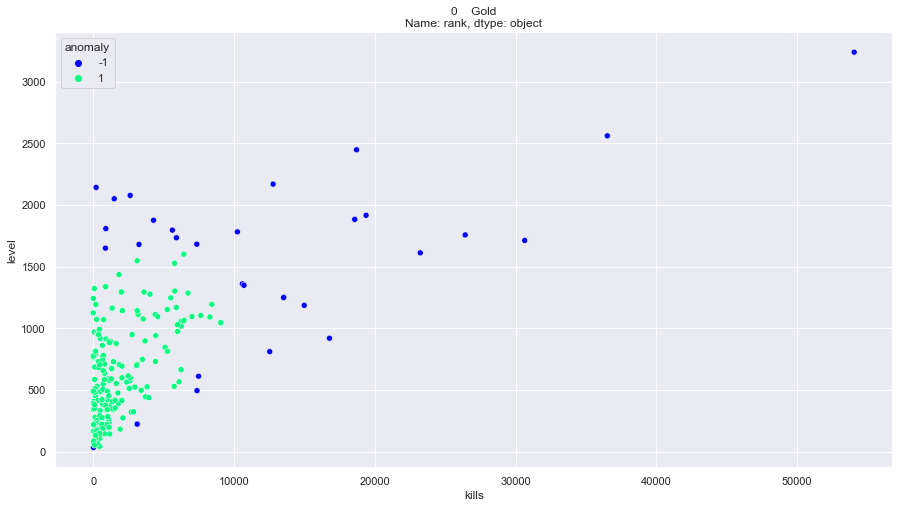

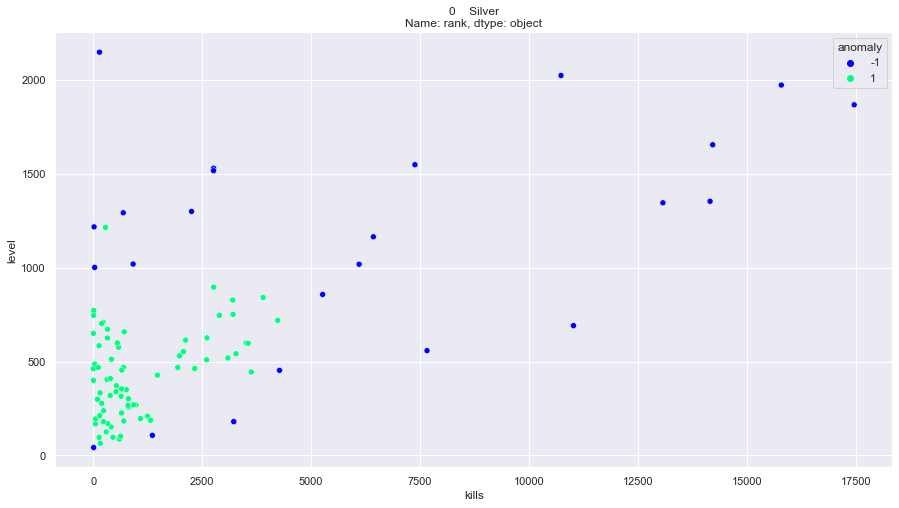

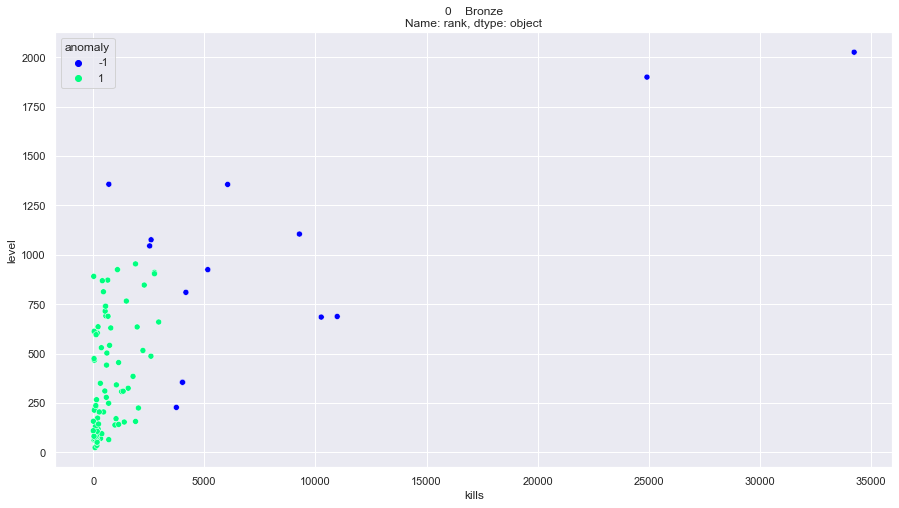

In [72]:
for i in df_list:
    sns.scatterplot(x='kills', y='level', data=i, hue='anomaly',palette="winter").set(title=str(i['rank'].mode()))
    plt.show()

In [73]:
# isolation forest
for i in df_list:
    clf = IsolationForest()
    clf.fit(i[['kills_log_scaled','level_log_scaled']])
    y_pred_train = clf.predict(i[['kills_log_scaled','level_log_scaled']])
    i['anomaly'] = pd.Series(y_pred_train)
    i['anomaly'] = i['anomaly'].replace(np.NaN, 0)

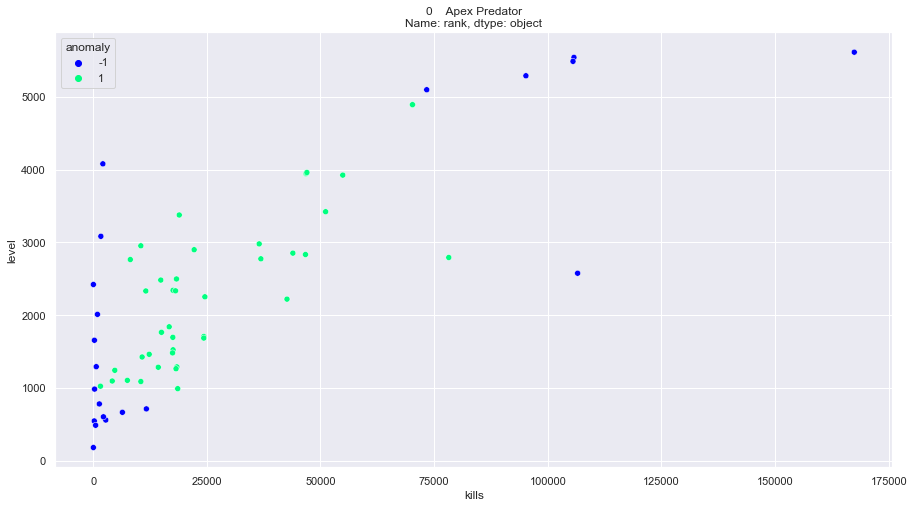

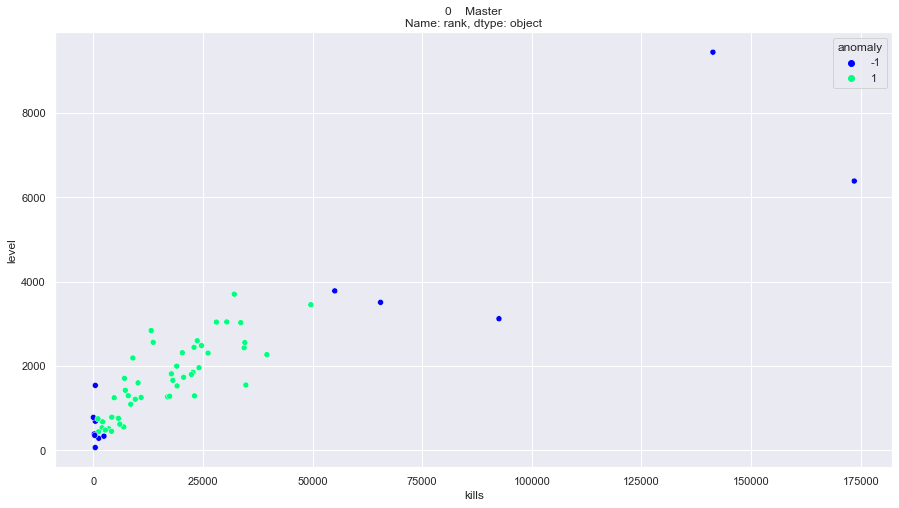

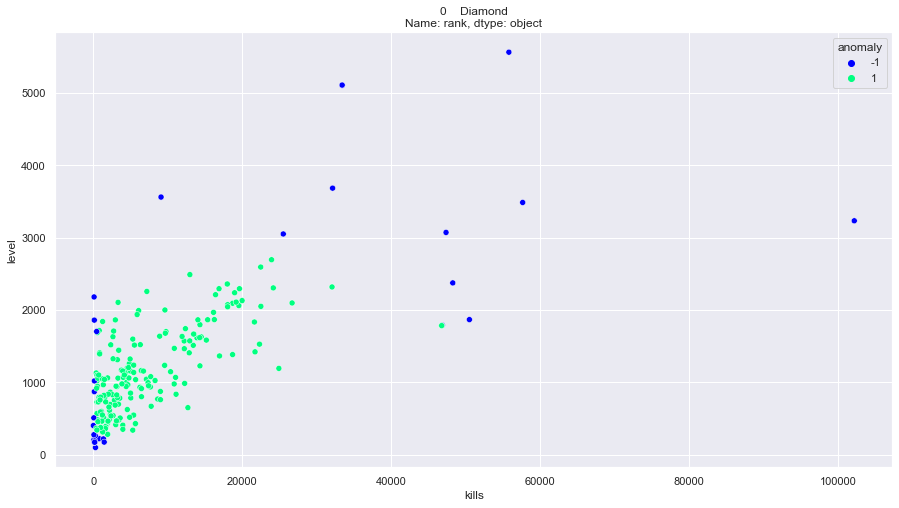

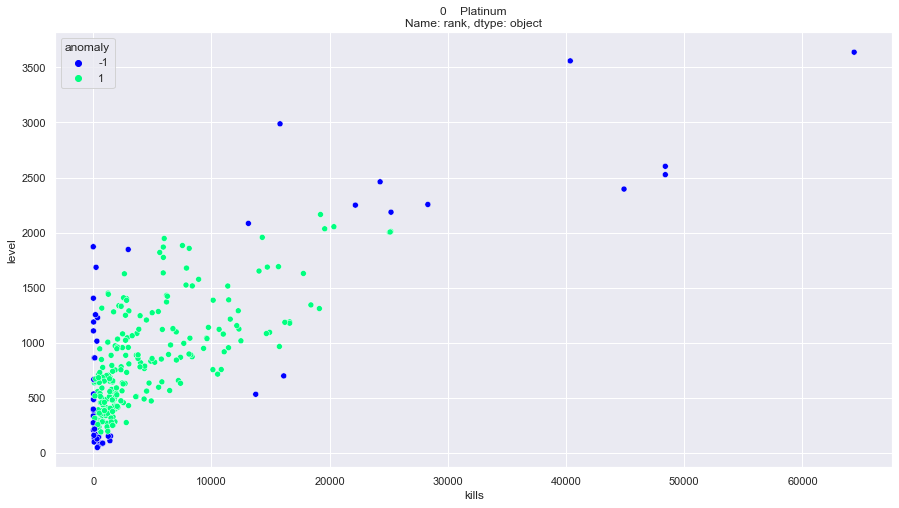

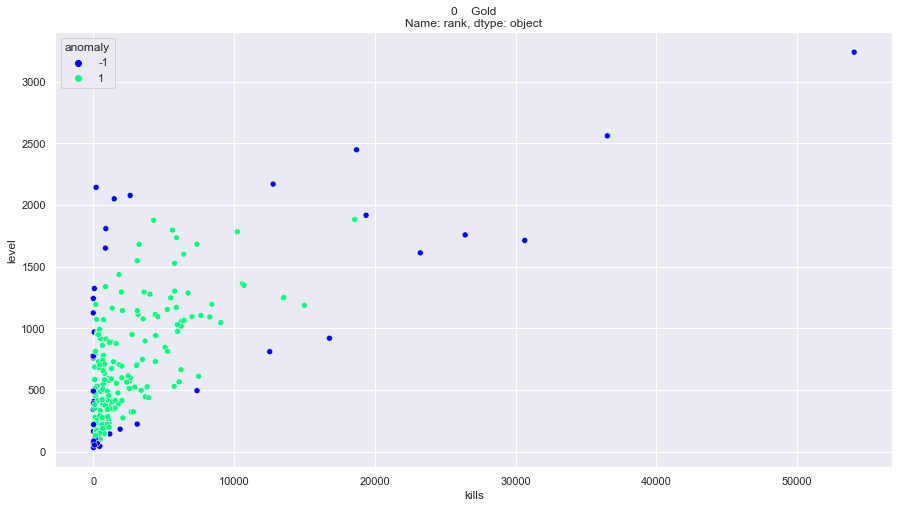

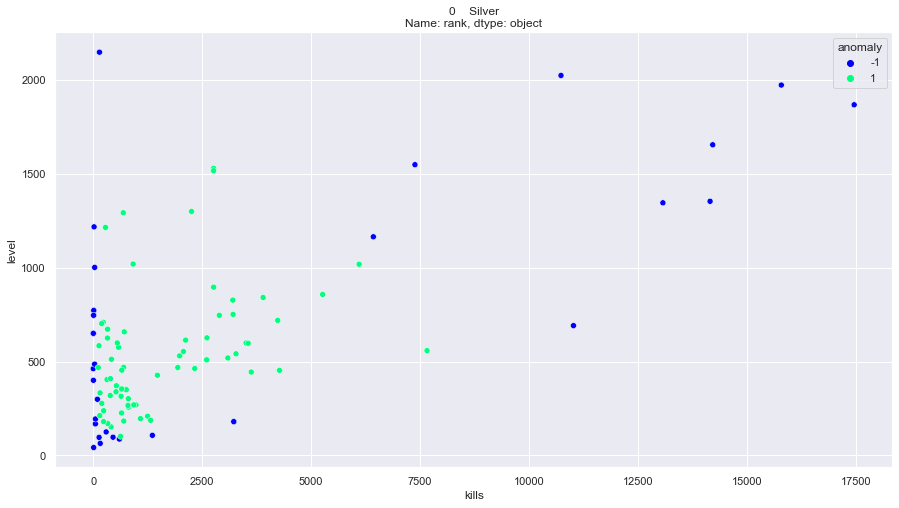

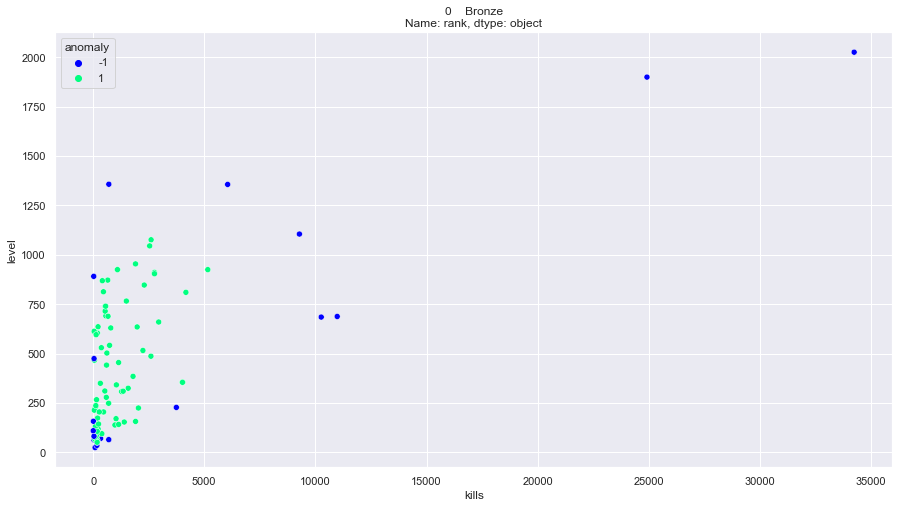

In [74]:
for i in df_list:
    sns.scatterplot(x='kills', y='level', data=i, hue='anomaly',palette="winter").set(title=str(i['rank'].mode()))
    plt.show()

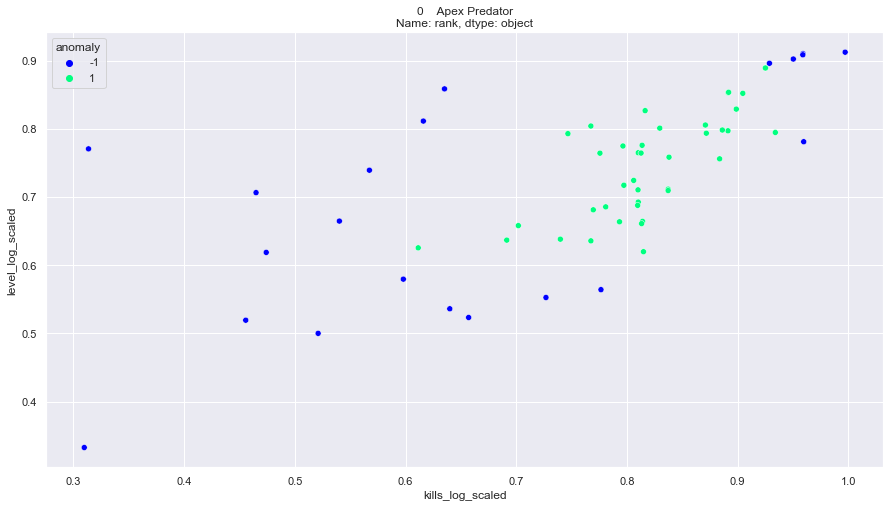

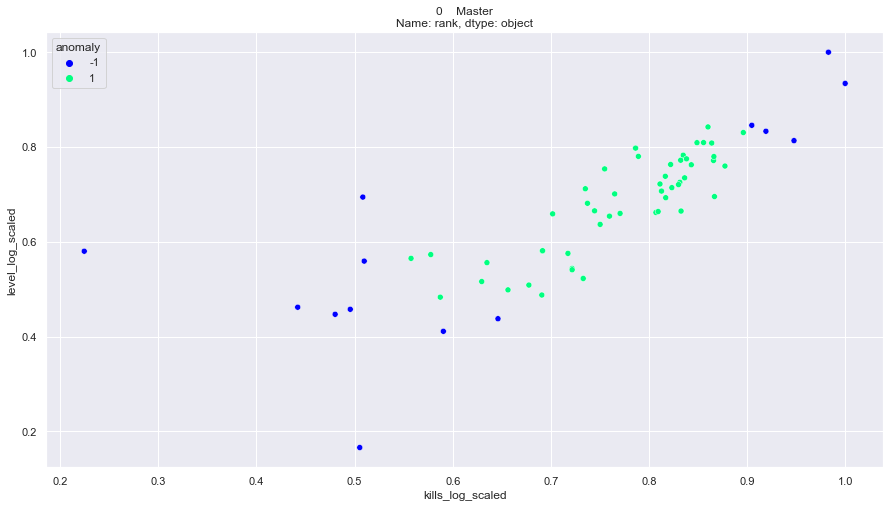

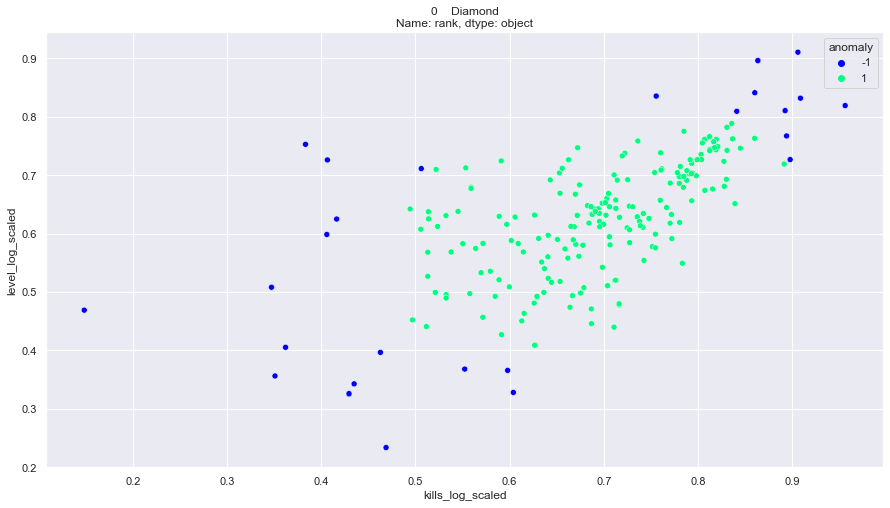

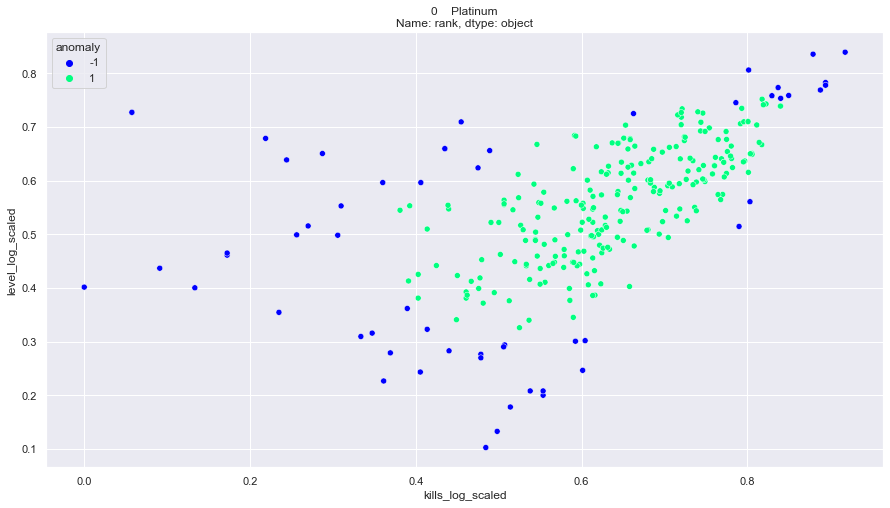

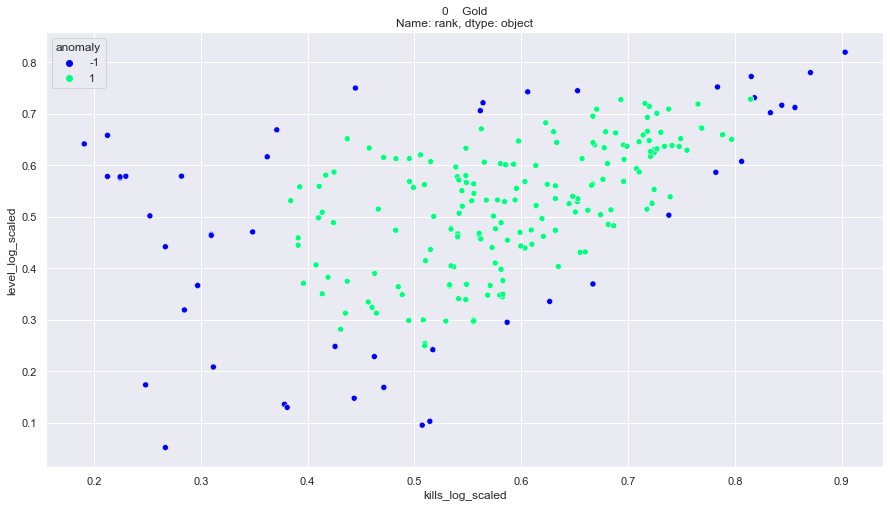

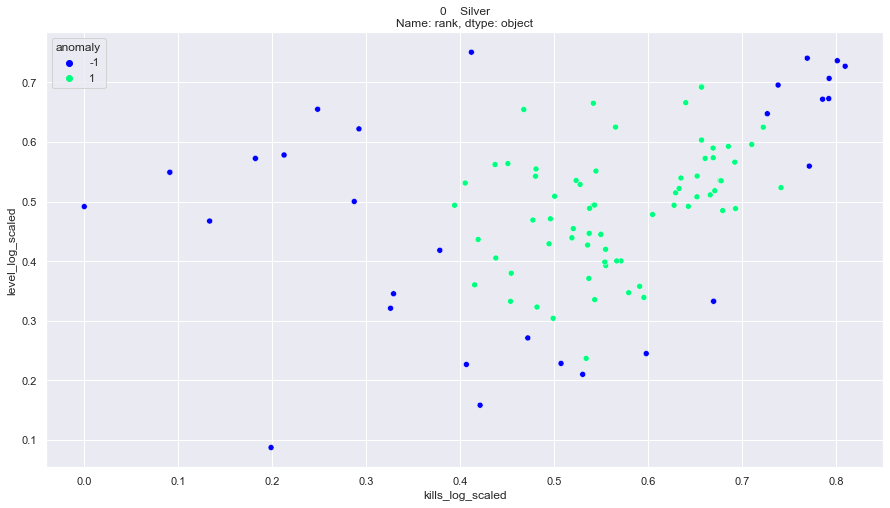

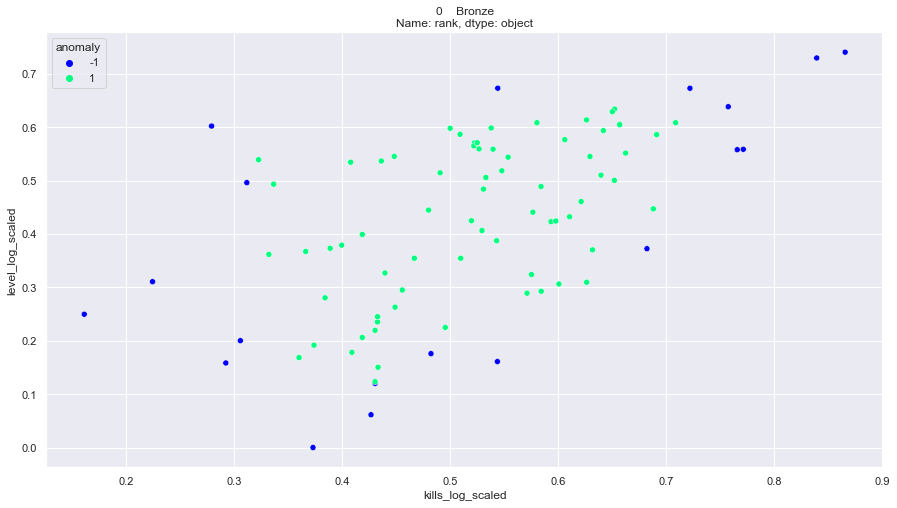

In [75]:
for i in df_list:
    sns.scatterplot(x='kills_log_scaled', y='level_log_scaled', data=i, hue='anomaly',palette="winter").set(title=str(i['rank'].mode()))
    plt.show()